# Neural style transfer

## Connect to home directory and set appropriate paths

In [1]:
#Connect drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Set data path
!cd '/content/drive/MyDrive/Style Transfer/'

In [3]:
!ls

drive  sample_data


In [4]:
data_dir = "/content/drive/MyDrive/Style Transfer/" # Base directory
content_path = data_dir + "japanese_garden.jpg" # Content Image Path
style_path = data_dir + "picasso_selfportrait.jpg" # Style Image Path

## Import and configure modules

In [5]:
import os
import tensorflow as tf # https://www.tensorflow.org/install/pip
import numpy as np
import time
import IPython.display as display
import PIL.Image # https://pypi.org/project/Pillow/
import matplotlib.pyplot as plt # https://matplotlib.org/users/installing.html
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

## Define utility functions

In [6]:
def load_img(path_to_img):
  '''Preprocess and load image.'''
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  
  return img

In [7]:
def disp_img(image, title=None):
  '''Display image.'''
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

In [8]:
def tensor_to_image(tensor):
  '''Return an image for a given tensor.'''
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
    
  return PIL.Image.fromarray(tensor)

In [9]:
def gram_matrix(input_tensor):
  '''Computes gram matrix.'''
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  
  return result/(num_locations)

## View inputs

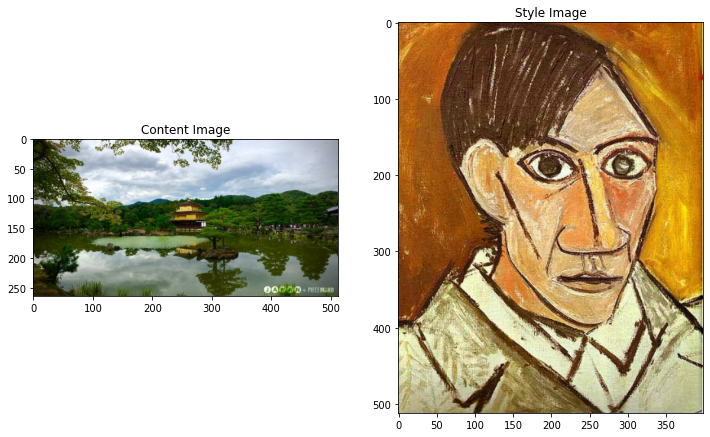

In [10]:
# Content image
content_image = load_img(content_path)
plt.subplot(1, 2, 1)
disp_img(content_image, 'Content Image')

# Style image
style_image = load_img(style_path)
plt.subplot(1, 2, 2)
disp_img(style_image, 'Style Image')

## Define and build model

In [11]:
# Check to see what layers are needed for our model
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

# Check layers present
for layer in vgg.layers:
  print(layer.name)

80142336/80134624 [==============================] - 0s 0us/step
input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [12]:
# Required content and style layers
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

In [13]:
# Base model
def vgg_layers(layer_names):
  '''Creates a vgg model that returns a list of intermediate output values.'''
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  
  return model

In [14]:
# Custom Model
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.num_content_layers = len(content_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    'Expects float input in [0,1]'
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)for style_output in style_outputs]

    content_dict = {content_name:value for content_name, value in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value for style_name, value in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

In [15]:
# Build model
extractor = StyleContentModel(style_layers, content_layers)

## Optimizer and losses

In [16]:
# Optimizer used
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [17]:
# Hyperparameters - weights of content loss, style loss and total variation loss
content_weight=1e4
style_weight=1e-2
variation_weight=30

In [18]:
def total_loss(image):
  '''Compute total loss inclusive of style loss, content loss and variation loss.'''
  outputs = extractor(image)

  # Style loss
  style_targets = extractor(style_image)['style']
  style_outputs = outputs['style']
  style_loss = tf.add_n([tf.reduce_mean((style_targets[name]-style_outputs[name])**2) for name in style_outputs.keys()])
  style_loss *= style_weight / extractor.num_style_layers

  # Content loss
  content_targets = extractor(content_image)['content']
  content_outputs = outputs['content']
  content_loss = tf.add_n([tf.reduce_mean((content_targets[name]-content_outputs[name])**2) for name in content_outputs.keys()])
  content_loss *= content_weight / extractor.num_content_layers

  # Variation loss
  loss = style_loss + content_loss
  loss += variation_weight*tf.image.total_variation(image)

  return loss

## Training

In [19]:
#@tf.function()
def train_step(image):
  '''Train model.'''
  with tf.GradientTape() as tape:
    loss = total_loss(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))

  return loss

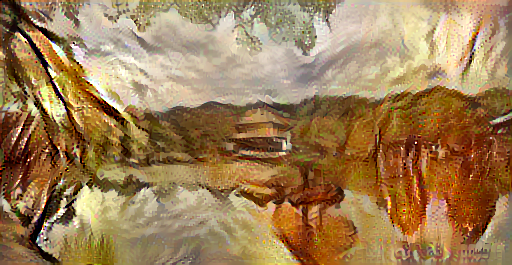

Train step: 1000
Loss Obtained =  tf.Tensor(4876084.0, shape=(), dtype=float32)
Total time: 325.4


In [20]:
# Training
image = tf.Variable(content_image)

epochs = 10
steps_per_epoch = 100

start = time.time()

loss = 0
step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    loss = train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()

print("Loss Obtained = ", loss[0])
print("Total time: {:.1f}".format(end-start))

## Save and view the output

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

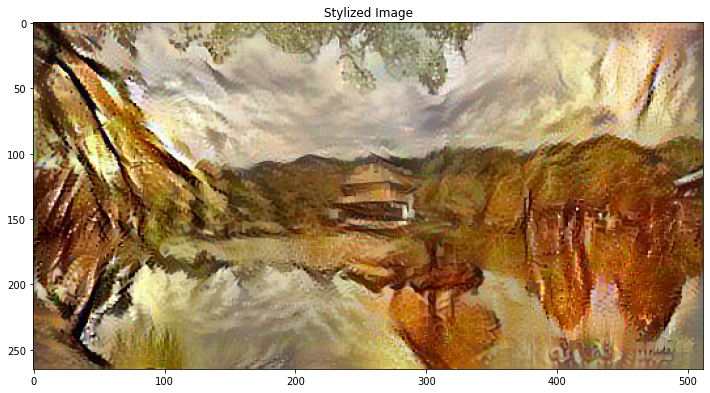

In [21]:
# Save stylized image
stylized_image_path = data_dir + 'stylized-image.jpg'
tensor_to_image(image).save(stylized_image_path)

# View stylized image
stylized_image = load_img(stylized_image_path)
disp_img(stylized_image, 'Stylized Image')

# Download stylized image
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(stylized_image_path)